In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [15, 8]

In [2]:
def get_image(path: str) -> np.ndarray:
    src = cv.imread(path)
    return cv.cvtColor(src, cv.COLOR_BGR2RGB)


def concatenate_images(img1: np.ndarray, img2: np.ndarray) -> np.ndarray:
    return np.concatenate((img1, img2), axis=1)


def warpImages(img1, img2, H):
    rows1, cols1 = img1.shape[:2]
    rows2, cols2 = img2.shape[:2]
    
    list_of_points_1 = np.float32([[0, 0], [0, rows1],[cols1, rows1], [cols1, 0]]).reshape(-1, 1, 2)
    temp_points = np.float32([[0, 0], [0, rows2], [cols2, rows2], [cols2,0]]).reshape(-1, 1, 2)
    
    list_of_points_2 = cv.perspectiveTransform(temp_points, H)
    list_of_points = np.concatenate((list_of_points_1, list_of_points_2), axis=0)

    [x_min, y_min] = np.int32(list_of_points.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(list_of_points.max(axis=0).ravel() + 0.5)

    translation_dist = [-x_min, -y_min]

    H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])

    output_img = cv.warpPerspective(img2, H_translation.dot(H), (x_max - x_min, y_max - y_min))
    output_img[translation_dist[1]:rows1+translation_dist[1], translation_dist[0]:cols1 + translation_dist[0]] = img1

    return output_img


def get_panoram_image(img1: np.ndarray, img2, nfeatures: int = 2000, ransac_threshold: float = 5, min_match_count: int = 10):
    orb = cv.ORB_create(nfeatures=nfeatures)
    keypoints1, descriptors1 = orb.detectAndCompute(img1, None)
    keypoints2, descriptors2 = orb.detectAndCompute(img2, None)

    bf = cv.BFMatcher_create(cv.NORM_HAMMING)

    # Find matching points
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)
    all_matches = []
    good_matches = []

    for m, n in matches:
        all_matches.append(m)

        if m.distance < 0.6 * n.distance:
            good_matches.append(m)
    
    if len(good_matches) > min_match_count:
        src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1,1,2)
        dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)

        M, _ = cv.findHomography(src_pts, dst_pts, cv.RANSAC, ransac_threshold)

        return warpImages(img2, img1, M)

    return 0



### Первый набор изображений

In [ ]:
images = []
for i in range(1, 6):
    images.append(get_image(f"buildings/building1/building{i}.jpg"))

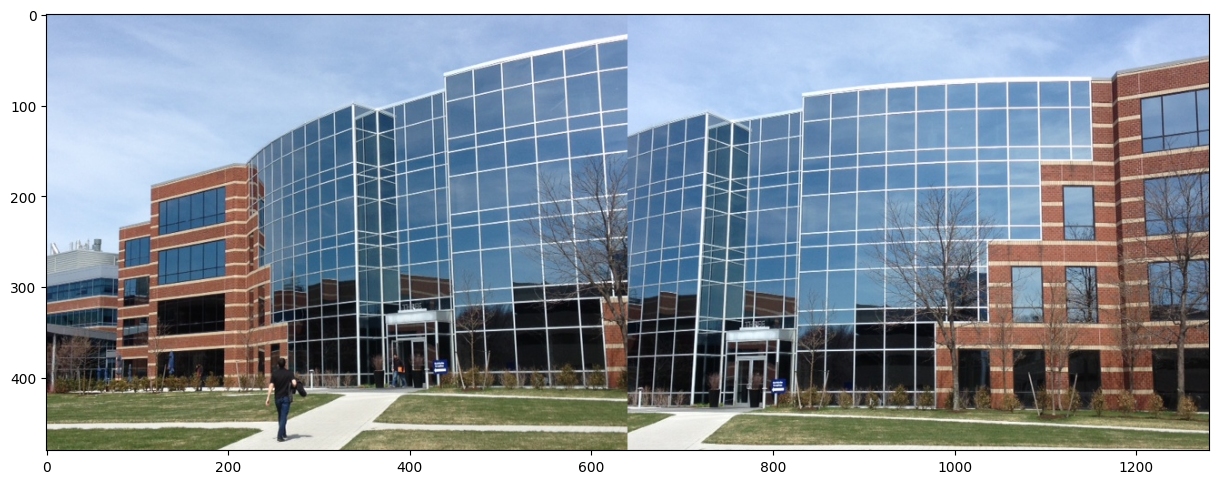

In [ ]:
plt.imshow(concatenate_images(images[0], images[1]))

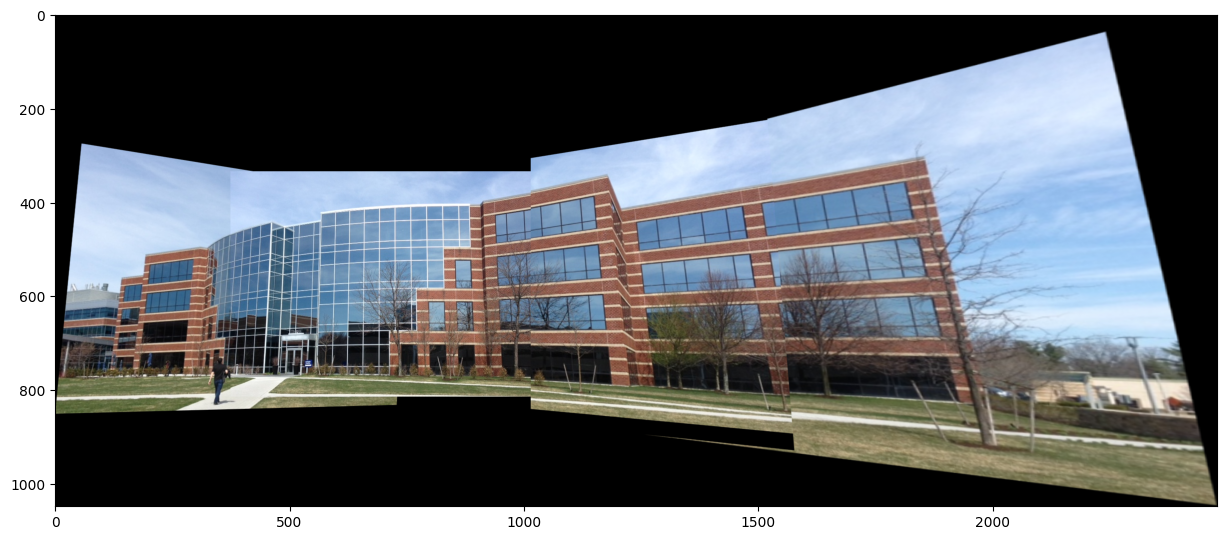

In [ ]:
result01 = get_panoram_image(images[0], images[1])
result23 = get_panoram_image(images[2], images[3], ransac_threshold=5)
result234 = get_panoram_image(images[4], result23)
result = get_panoram_image(result234, result01)
plt.imshow(result)

Обрежем пустую часть изображения

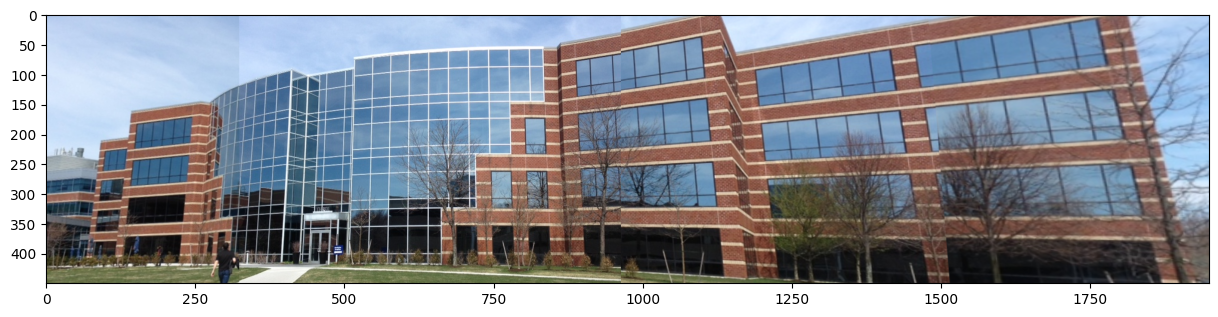

In [ ]:
plt.imshow(result[350:800, 50:2000])

### Второй набор изображений

In [122]:
images = []
images.append(get_image("buildings/building2/dsc_2707.jpg"))
images.append(get_image("buildings/building2/dsc_2708.jpg"))
images.append(get_image("buildings/building2/dsc_2709.jpg"))
images.append(get_image("buildings/building2/dsc_2710.jpg"))
images.append(get_image("buildings/building2/dsc_2711.jpg"))

Склеим правую часть изображения

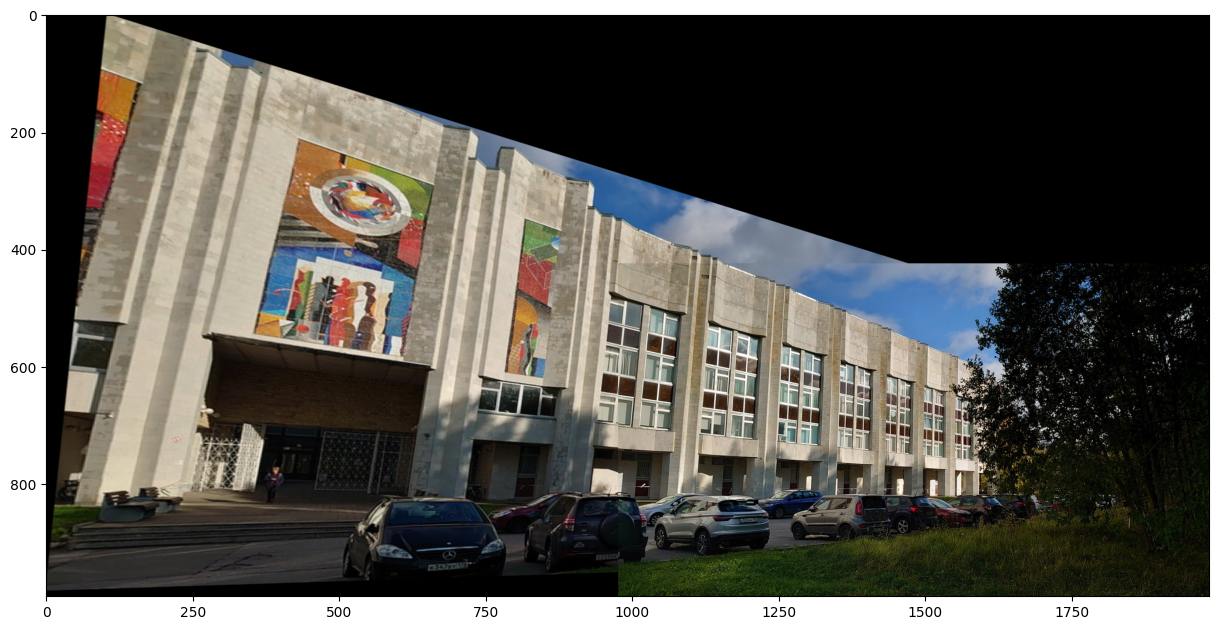

In [123]:
result01 = get_panoram_image(images[1], images[0])
plt.imshow(result01)

Склеим левую часть изображения

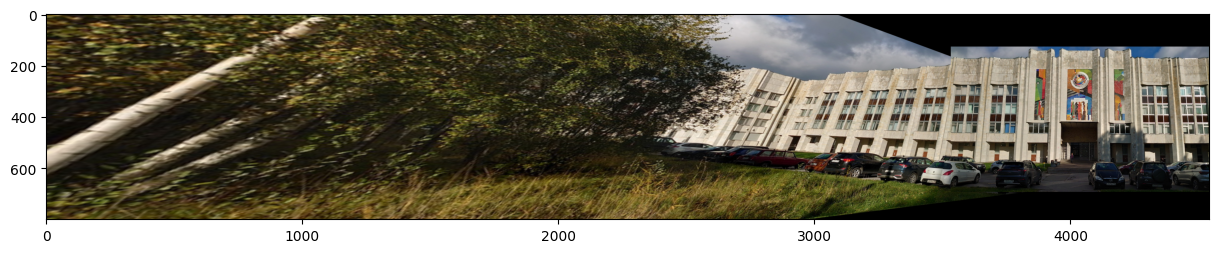

In [124]:
result34 = get_panoram_image(images[3], images[4])[210:780, :1650]
result234 = get_panoram_image(result34, images[2], ransac_threshold=0.1)[800:1600, 5000:]
plt.imshow(result234)

Склеим изображение целиком

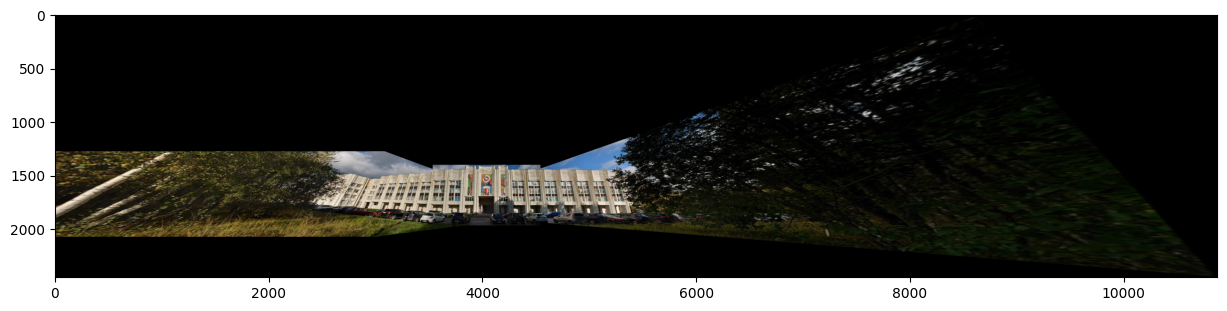

In [125]:
result = get_panoram_image(result01[450:900, 100:], result234)
plt.imshow(result)

Обрежем пустые границы

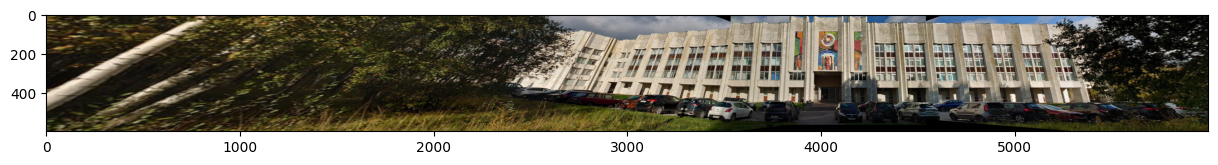

In [126]:
plt.imshow(result[1400:2000, :6000])

### Третий набор изображений

In [34]:
images = []
for i in range(21, 28):
    images.append(get_image(f"buildings/building3/dsc_27{i}.jpg"))

Склеим правую часть изображения

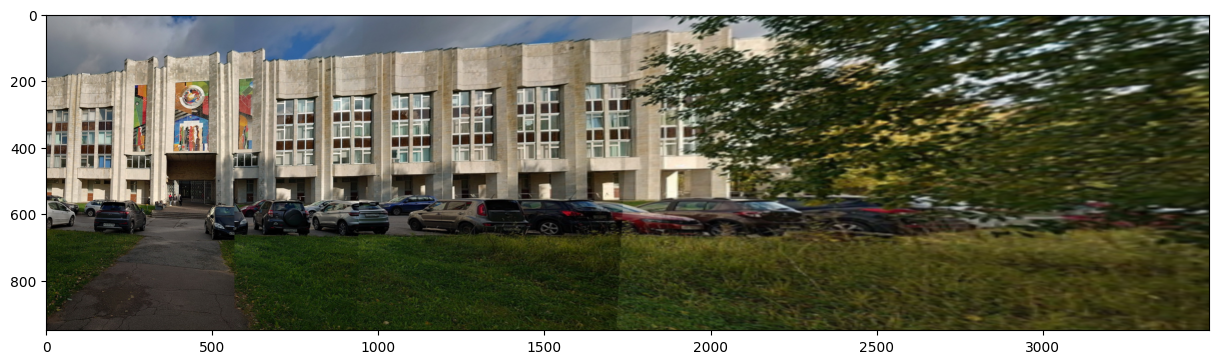

In [114]:
result01 = get_panoram_image(images[0], images[1])
result012 = get_panoram_image(result01, images[2])[580:1580, :1750]
result0123 = get_panoram_image(result012, images[3], ransac_threshold=0.0000001)[950:1900, :3500]
plt.imshow(result0123)

Склеим левую часть изображения

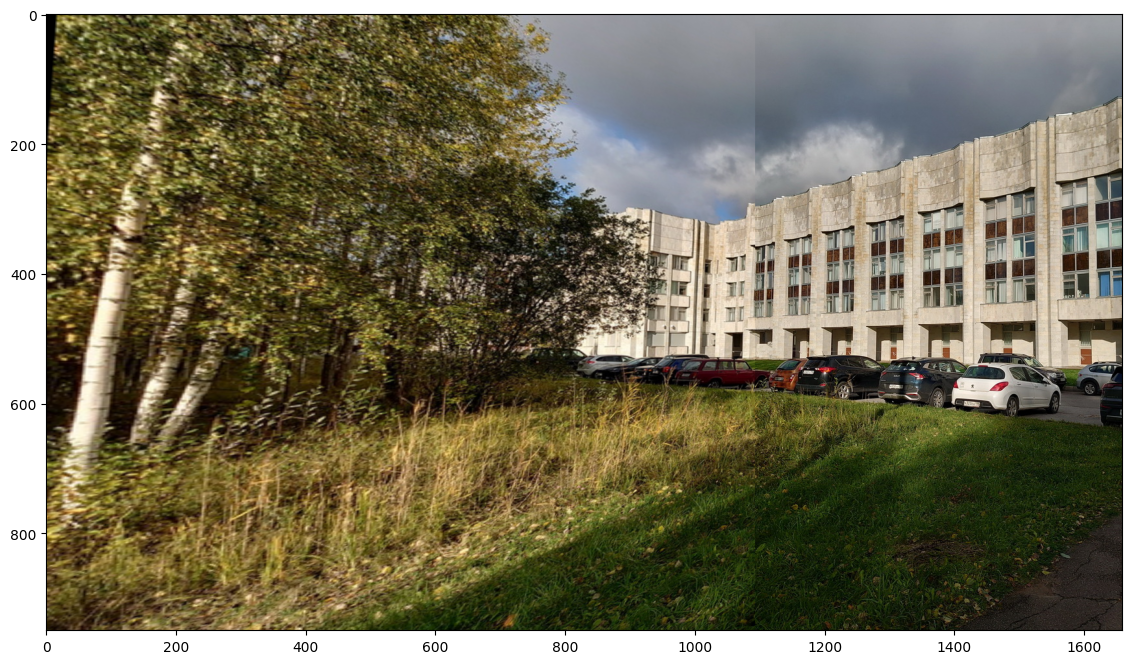

In [116]:
result56 = get_panoram_image(images[5], images[6])
result456 = get_panoram_image(result56, images[4])[950:1900, 100:]
plt.imshow(result456)

Склеим изображение целиком

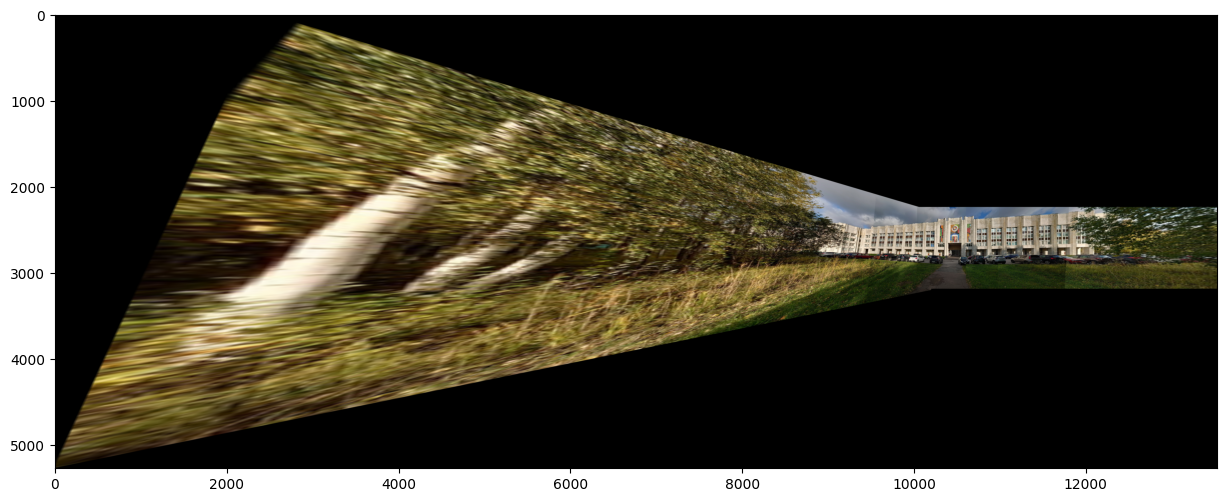

In [117]:
result = get_panoram_image(result456, result0123)
plt.imshow(result)

Обрежем пустые границы

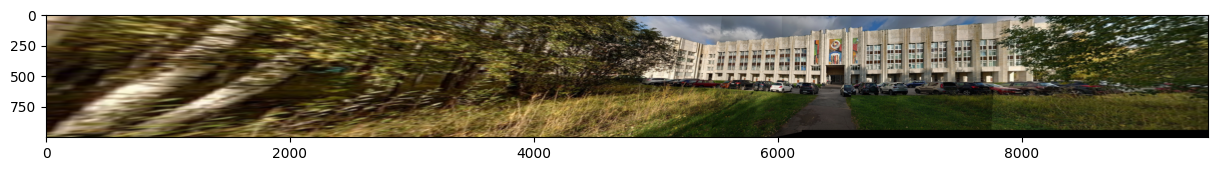

In [118]:
plt.imshow(result[2250:3250, 4000:])